In [53]:
!pip install boto3

In [54]:
import copy
import os
import boto3
import traceback
import io
import json

import pandas as pd
import numpy as np

from botocore.exceptions import ClientError, NoCredentialsError
from traceback import format_exc

In [55]:
os.environ['AWS_ACCESS_KEY_ID'] = <access_key>
os.environ['AWS_SECRET_ACCESS_KEY'] = <secret_access_key>

In [56]:
BUCKET = 'russian-stocks-quotes'

access_key = os.getenv('AWS_ACCESS_KEY_ID')
secret_key = os.getenv('AWS_SECRET_ACCESS_KEY')
endpoint_url = 'https://storage.yandexcloud.net'

# Создание клиента S3
s3_client = boto3.client('s3',
                         region_name='ru-central1',
                         aws_access_key_id=access_key,
                         aws_secret_access_key=secret_key,
                         endpoint_url=endpoint_url)

def upload_object_to_s3(key, body):
    response = s3_client.put_object(Bucket=BUCKET, Key=key, Body=body)
    if response['ResponseMetadata']['HTTPStatusCode'] == 200:
        print(f"Успешно сохранен в {BUCKET}/{key}")
    else:
        print(f"Ошибка при сохранении: {response['ResponseMetadata']['HTTPStatusCode']}")

def upload_data_frame_to_s3(secid, data_frame, dir):
    pickle_buffer = io.BytesIO()
    data_frame.to_pickle(pickle_buffer)
    pickle_buffer.seek(0)
    data_frame_file = f'{dir}secids/{secid}/{secid}_data_frame.pkl'
    upload_object_to_s3(data_frame_file, pickle_buffer)

def upload_info_to_s3(secid, info, dir):
    info['miss_index'] = info['miss_index'].to_numpy().tolist()
    json_data = json.dumps(info)
    info_file = f'{dir}secids/{secid}/{secid}_info.pkl'
    upload_object_to_s3(info_file, json_data)

def upload_secid_names(dict_data, dir):
    json_data = json.dumps(list(dict_data.keys()))
    secid_names_file = f'{dir}secid_names.pkl'
    upload_object_to_s3(secid_names_file, json_data)

def upload_data_to_s3(dict_data, dir):
    try:
        upload_secid_names(dict_data, dir)
        for secid, data in dict_data.items():
            copy_data = copy.deepcopy(data)
            upload_data_frame_to_s3(secid, copy_data['data_frame'], dir)
            del copy_data['data_frame']
            upload_info_to_s3(secid, copy_data, dir)
    except ClientError as e:
        print(f"Произошла ошибка: {e.response['Error']['Message']}")
    except Exception as e:
        error_message = f"Неизвестная ошибка: {str(e)}"
        error_context = traceback.format_exc()
        print(f"{error_message}\nКонтекст ошибки:\n{error_context}")

def list_directories(s3_client):
    directories = set()
    try:
        paginator = s3_client.get_paginator('list_objects_v2')
        for page in paginator.paginate(Bucket=BUCKET, Delimiter='/'):
            for prefix in page.get('CommonPrefixes', []):
                directories.add(prefix.get('Prefix'))
    except NoCredentialsError:
        print("Ошибка: Неверные учетные данные.")
    except Exception as e:
        print(f"Произошла ошибка: {e}")
    return directories

def download_object_from_s3(key):
    response = s3_client.get_object(Bucket=BUCKET, Key=key)
    if response['ResponseMetadata']['HTTPStatusCode'] == 200:
        print(f"Успешно получен из {BUCKET}/{key}")
    else:
        print(f"Ошибка при получении: {response['ResponseMetadata']['HTTPStatusCode']}")
    return response['Body'].read()

def download_info_from_s3(dir, secid):
    key = f'{dir}secids/{secid}/{secid}_info.pkl'
    response = download_object_from_s3(key)
    data = json.loads(response)
    data['miss_index'] = pd.Index(np.array(data['miss_index']))
    return data

def download_data_frame_from_s3(dir, secid):
    key = f'{dir}secids/{secid}/{secid}_data_frame.pkl'
    response = download_object_from_s3(key)
    buffer = io.BytesIO(response)
    data = pd.read_pickle(buffer)
    data['TRADEDATE'] = pd.to_datetime(data['TRADEDATE'])
    return data

def download_secid_names(dir):
    key = f'{dir}secid_names.pkl'
    return json.loads(download_object_from_s3(key))

def download_data_from_s3(dir, secids=None):
    data = {}
    try:
        directories = download_secid_names(dir)
        for secid in directories:
            if secids is None or secid in secids:
                if secids is not None:
                    secids.remove(secid)
                data[secid] = download_info_from_s3(dir, secid)
                data[secid]['data_frame'] = download_data_frame_from_s3(dir, secid)
    except Exception as e:
        error_message = f"Неизвестная ошибка: {str(e)}"
        error_context = traceback.format_exc()
        print(f"{error_message}\nКонтекст ошибки:\n{error_context}")
    if secids is not None and len(secids) > 0:
        print(f'Не нашли {secids}')
    return data

In [57]:
data_frames = download_data_from_s3('data_without_preprocessing/')

Успешно получен из russian-stocks-quotes/data_without_preprocessing/secid_names.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/APRI/APRI_info.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/APRI/APRI_data_frame.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/KLVZ/KLVZ_info.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/KLVZ/KLVZ_data_frame.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/ASTR/ASTR_info.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/ASTR/ASTR_data_frame.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/ACKO/ACKO_info.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/ACKO/ACKO_data_frame.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/AVAZP/AVAZP_info.pkl
Успешно получен из russian-stocks-quotes/dat

Загрузим дополнительные библиотеки.

In [58]:
import matplotlib.pyplot as plt

Посмотрим пропуски в данных.

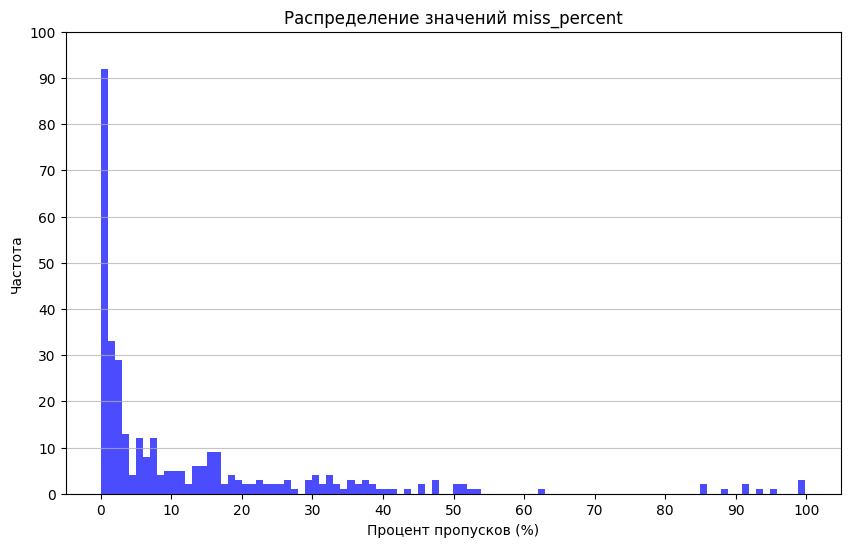

In [59]:
miss_percents = [data['miss_percent'] for data in data_frames.values()]
miss_df = pd.DataFrame(miss_percents, columns=['miss_percent'])
plt.figure(figsize=(10, 6))
plt.hist(miss_df['miss_percent'], bins=100, color='blue', alpha=0.7)
plt.title('Распределение значений miss_percent')
plt.xlabel('Процент пропусков (%)')
plt.ylabel('Частота')
plt.xticks(np.arange(0, 101, step=10))
plt.yticks(np.arange(0, 101, step=10))
plt.grid(axis='y', alpha=0.75)
plt.show()

Можем посмотреть разницу цен между днями в абсолютном значении и в процентах.

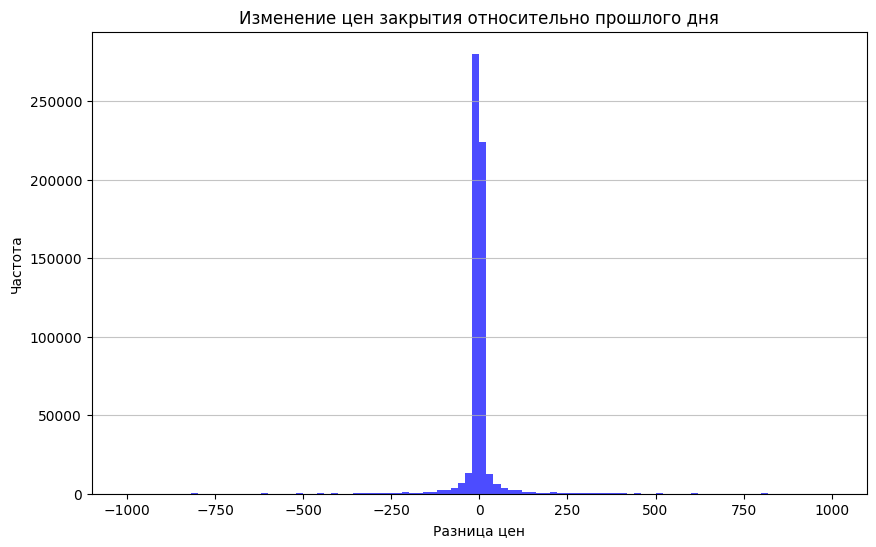

In [60]:
close_diffs = []
for secid, data in data_frames.items():
    close_diffs.extend([diff for diff in data['data_frame']['CLOSE'].dropna().diff()[1:]])
close_diffs = [item for item in close_diffs if item > -1000 and item < 1000]
plt.figure(figsize=(10, 6))
plt.hist(close_diffs, bins=100, color='blue', alpha=0.7)
plt.title('Изменение цен закрытия относительно прошлого дня')
plt.xlabel('Разница цен')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

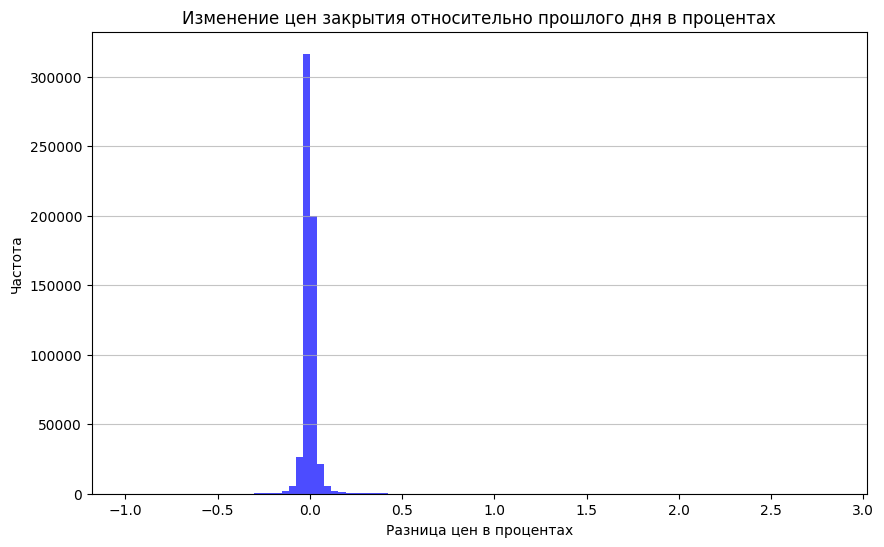

In [61]:
close_diffs = []
for secid, data in data_frames.items():
    close_diffs.extend([diff for diff in data['data_frame']['CLOSE'].dropna().pct_change()[1:]])
close_diffs = [item for item in close_diffs if item < 10]
plt.figure(figsize=(10, 6))
plt.hist(close_diffs, bins=100, color='blue', alpha=0.7)
plt.title('Изменение цен закрытия относительно прошлого дня в процентах')
plt.xlabel('Разница цен в процентах')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

Какой-то зависимости так через график незаметно.

Обработаем данные удалив начальные пропуски, которые не будут полезны.

In [62]:
def find_first_normal_index(data):
    full_index = np.arange(0, data['data_frame'].shape[0] + 1)
    missing_values = np.setdiff1d(full_index, data['miss_index'])
    return missing_values[0]

filtered_data_frames = copy.deepcopy(data_frames)
for secid, data in filtered_data_frames.items():
    first_not_missed = find_first_normal_index(data)
    if first_not_missed != 0:
        data['data_frame'] = data['data_frame'].iloc[first_not_missed:]
        data['data_frame'].reset_index(drop=True, inplace=True)
        data['miss_index'] = data['miss_index'][data['miss_index'] >= first_not_missed] - first_not_missed
        data['miss_count'] = int(data['miss_count'] - first_not_missed)
        data['row_count'] = int(data['row_count'] - first_not_missed)
        data['miss_percent'] = float(data['miss_count'] / data['row_count'] * 100)

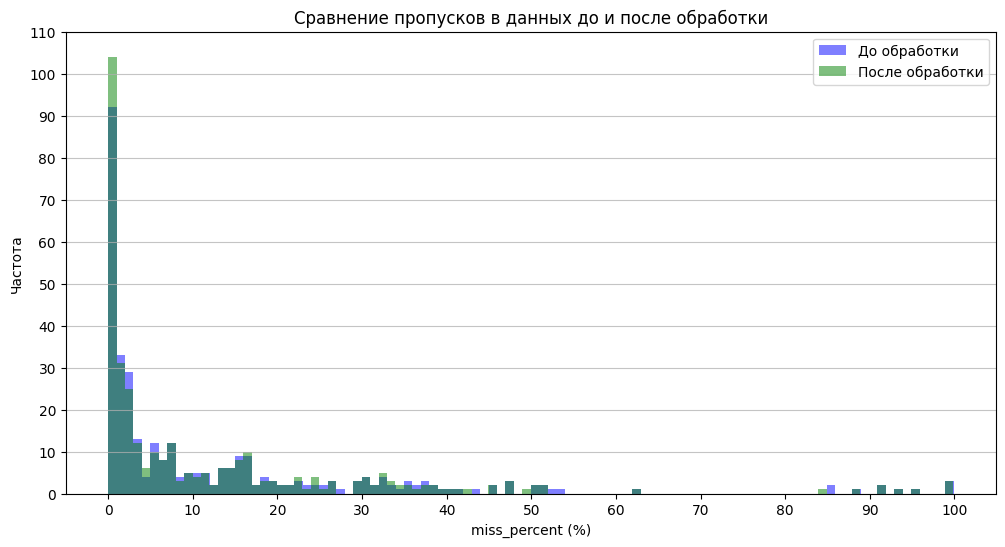

In [63]:
miss_percents_before = [data['miss_percent'] for data in data_frames.values()]
miss_percents_after = [data['miss_percent'] for data in filtered_data_frames.values()]

miss_df_before = pd.DataFrame(miss_percents_before, columns=['miss_percent'])
miss_df_after = pd.DataFrame(miss_percents_after, columns=['miss_percent'])

plt.figure(figsize=(12, 6))
plt.hist(miss_df_before['miss_percent'], bins=100, color='blue', alpha=0.5, label='До обработки')
plt.hist(miss_df_after['miss_percent'], bins=100, color='green', alpha=0.5, label='После обработки')

plt.title('Сравнение пропусков в данных до и после обработки')
plt.xlabel('miss_percent (%)')
plt.ylabel('Частота')
plt.xticks(np.arange(0, 101, step=10))
plt.yticks(np.arange(0, 111, step=10))
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

Как можно увидеть немного удалось улучшить. Чуть больше 10 таблиц удалось если не полностью избавить от пропусков, то приблизить к 0.

In [64]:
diffs = [item for item in miss_df_before['miss_percent'] - miss_df_after['miss_percent'] if item > 0.00001]
print(f"Средний процент пропусков до: {miss_df_before['miss_percent'].mean()}")
print(f"Средний проуент пропусков после: {miss_df_after['miss_percent'].mean()}")
print(f'Минимальное улучшение: {min(diffs)}%, Самое удачное: {max(diffs)}%')

Средний процент пропусков до: 12.808210053209585
Средний проуент пропусков после: 12.181561590135022
Минимальное улучшение: 0.008031681035475913%, Самое удачное: 84.40332507585359%


Дальше приведено изменение числа данных для каждой бумаги.

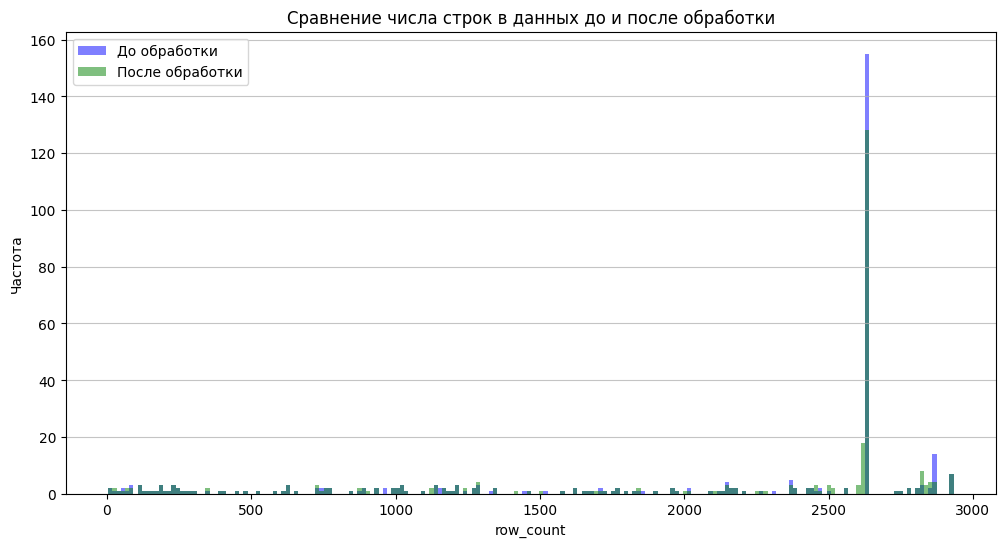

In [65]:
row_counts_before = [data['row_count'] for data in data_frames.values()]
row_counts_after = [data['row_count'] for data in filtered_data_frames.values()]

row_df_before = pd.DataFrame(row_counts_before, columns=['row_count'])
row_df_after = pd.DataFrame(row_counts_after, columns=['row_count'])

plt.figure(figsize=(12, 6))
plt.hist(row_df_before['row_count'], bins=200, color='blue', alpha=0.5, label='До обработки')
plt.hist(row_df_after['row_count'], bins=200, color='green', alpha=0.5, label='После обработки')

plt.title('Сравнение числа строк в данных до и после обработки')
plt.xlabel('row_count')
plt.ylabel('Частота')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

Для нормального предсказания буду брать данные с пропуском не более 10%.

In [66]:
normal_start_dataframe_data = {secid: data for secid, data in filtered_data_frames.items() if data['miss_percent'] <= 10}
len(normal_start_dataframe_data)

216

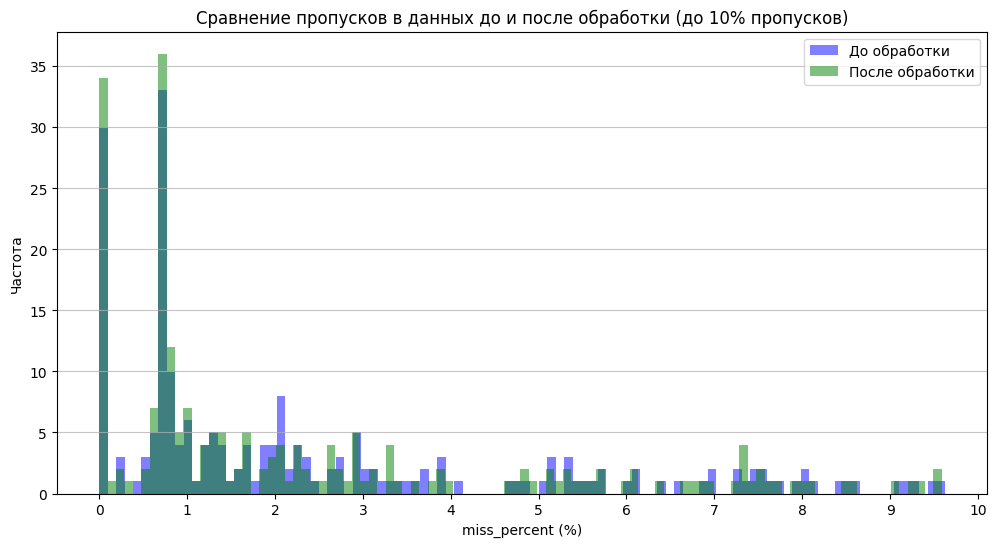

In [67]:
miss_percents_before = [data['miss_percent'] for data in data_frames.values() if data['miss_percent'] <= 10]
miss_percents_after = [data['miss_percent'] for data in normal_start_dataframe_data.values()]

miss_df_before = pd.DataFrame(miss_percents_before, columns=['miss_percent'])
miss_df_after = pd.DataFrame(miss_percents_after, columns=['miss_percent'])

plt.figure(figsize=(12, 6))
plt.hist(miss_df_before['miss_percent'], bins=100, color='blue', alpha=0.5, label='До обработки')
plt.hist(miss_df_after['miss_percent'], bins=100, color='green', alpha=0.5, label='После обработки')

plt.title('Сравнение пропусков в данных до и после обработки (до 10% пропусков)')
plt.xlabel('miss_percent (%)')
plt.ylabel('Частота')
plt.xticks(np.arange(0, 11, step=1))
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [68]:
upload_data_to_s3(normal_start_dataframe_data, 'normal_start/')

Успешно сохранен в russian-stocks-quotes/normal_start/secid_names.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/APRI/APRI_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/APRI/APRI_info.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/KLVZ/KLVZ_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/KLVZ/KLVZ_info.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/ASTR/ASTR_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/ASTR/ASTR_info.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/AVAZP/AVAZP_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/AVAZP/AVAZP_info.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/AVAZ/AVAZ_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/AVAZ/AVAZ_info.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/DATA/DATA_data_frame.pkl
Успешно со

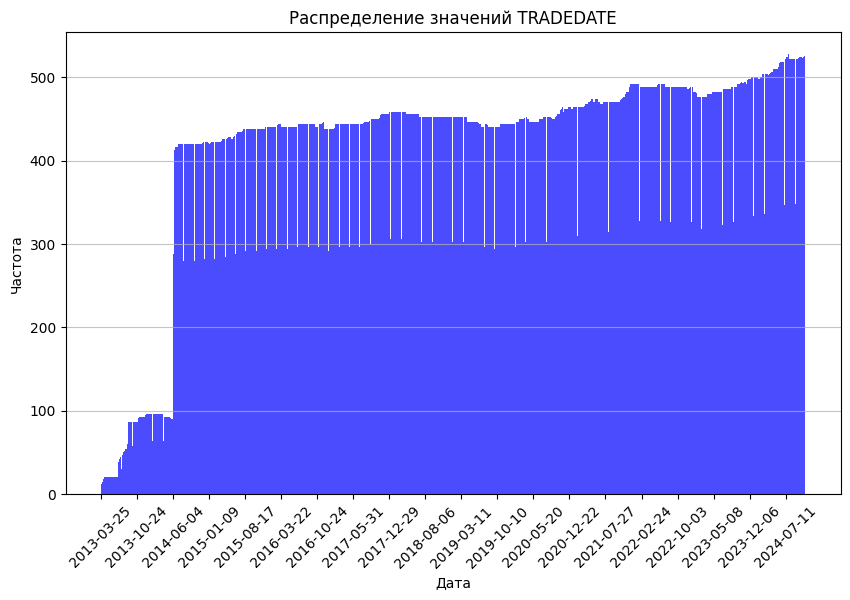

In [69]:
import matplotlib.pyplot as plt

tradedate = []
for data in normal_start_dataframe_data.values():
    tradedate.extend(data['data_frame']['TRADEDATE'].apply(lambda x: x.strftime('%Y-%m-%d')).tolist())
tradedate_df = pd.DataFrame(sorted(tradedate), columns=['TRADEDATE'])
plt.figure(figsize=(10, 6))
plt.hist(tradedate_df['TRADEDATE'], bins=1000, color='blue', alpha=0.7)
plt.title('Распределение значений TRADEDATE')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.xticks(list(sorted(set(tradedate_df['TRADEDATE'])))[::150], rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

Есть аномальные спуски, которые разберем чуть ниже и можно видеть быстрый рост в 2014 году, видимо из-за событий в мире множество компаний начали котироваться на мосбирже, что и привело к такому резкому росту и объясняет почему так много компаний были с ~2600 записями, потому что они все вышли на биржу в 2014, а может просто по какой-то причине для множества акций сохранились данные только от тех дат.

In [70]:
counts_df = tradedate_df.value_counts().reset_index()
counts_df.columns = ['TRADEDATE', 'count']
counts_df['TRADEDATE'] = pd.to_datetime(counts_df['TRADEDATE'])
sorted_counts_df = counts_df.sort_values(by='TRADEDATE', ascending=False)
selected_df = sorted_counts_df[(sorted_counts_df['TRADEDATE'] >= '2023-09-01') & (sorted_counts_df['TRADEDATE'] <= '2024-11-05')]

Как види разница небольшая и непонятно откуда брались те аномалии.

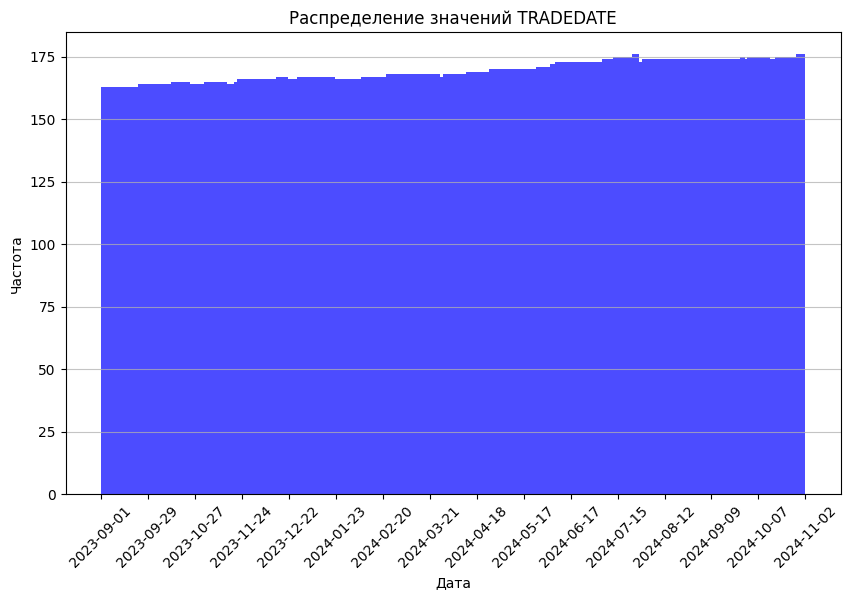

In [71]:
selected_df = pd.DataFrame(sorted([td for td in tradedate if td >= '2023-09-01' and td <= '2024-11-05']), columns=['TRADEDATE'])
plt.figure(figsize=(10, 6))
plt.hist(selected_df['TRADEDATE'], bins=301, color='blue', alpha=0.7)
plt.title('Распределение значений TRADEDATE')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.xticks(list(sorted(set(selected_df['TRADEDATE'])))[::20], rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

На этом графике лучше видно и как можно понять нет аномалий, может только непонятные минимальные спуски, следовательно в том графике были просто объединения нескольких колонок, что и давало странные выбросы.

Ещё можем посмотреть на то сколько было продаж в день и сколько денег на это тратилось.

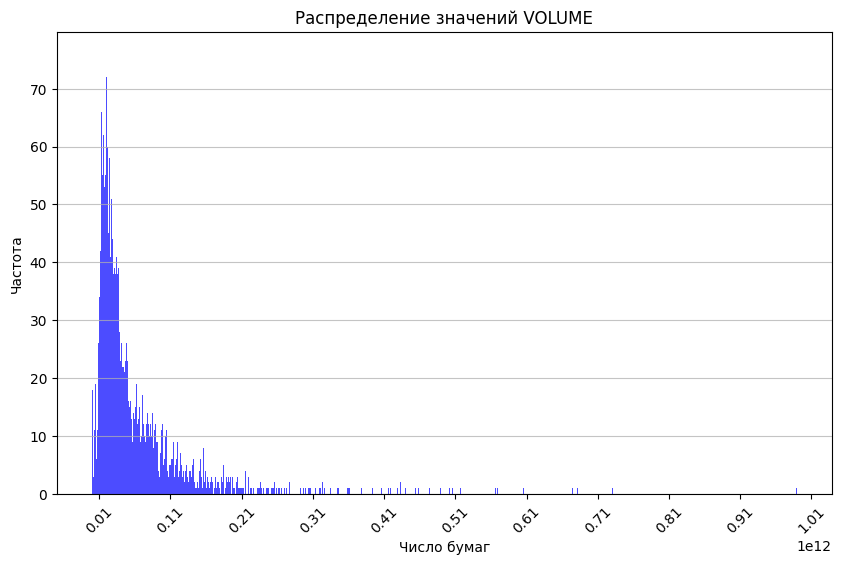

In [72]:
df = copy.deepcopy(normal_start_dataframe_data)
dataframes = list(map(lambda x: x['data_frame'][['TRADEDATE', 'VOLUME']], df.values()))
all_data = pd.concat(dataframes)
all_data = all_data.groupby('TRADEDATE', as_index=False)['VOLUME'].sum()
plt.figure(figsize=(10, 6))
plt.hist(all_data['VOLUME'], bins=1000, color='blue', alpha=0.7)
plt.title('Распределение значений VOLUME')
plt.xlabel('Число бумаг')
plt.ylabel('Частота')
plt.xticks(np.arange(1e10, 11e11, step=10e10), rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

Опять же понятно, что идет наложение, но видно что подавляющее большинство сделок в день от 1e10 до 1e11.

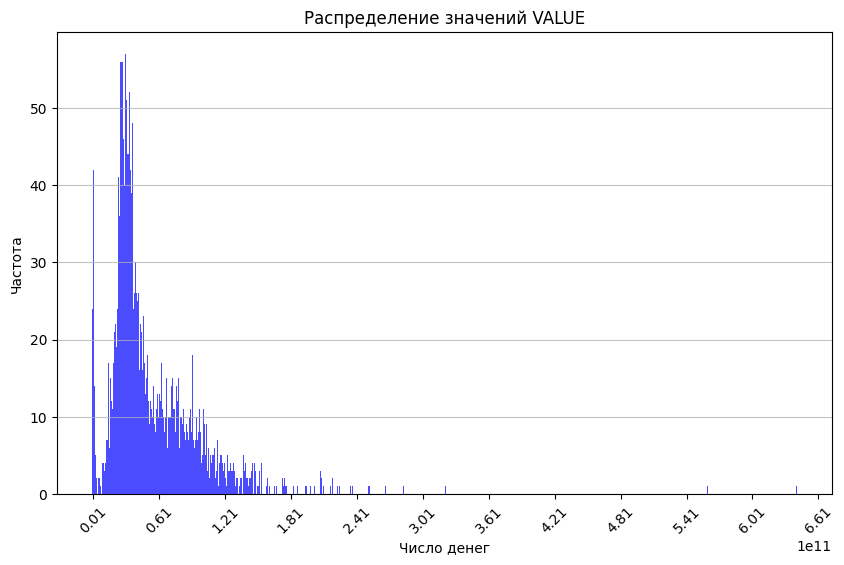

In [73]:
df = copy.deepcopy(normal_start_dataframe_data)
dataframes = list(map(lambda x: x['data_frame'][['TRADEDATE', 'VALUE']], df.values()))
all_data = pd.concat(dataframes)
all_data = all_data.groupby('TRADEDATE', as_index=False)['VALUE'].sum()
plt.figure(figsize=(10, 6))
plt.hist(all_data['VALUE'], bins=1000, color='blue', alpha=0.7)
plt.title('Распределение значений VALUE')
plt.xlabel('Число денег')
plt.ylabel('Частота')
plt.xticks(np.arange(1e9, 70e10, step=6e10), rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

Может быть удивительным, что распределение денег находится ниже, думаю это связано с тем, что есть бумаги, которые стоят меньше рубля и они покупаются в больших количествах, даже если тратится на это не так много.

Ну и небольшие примеры графиков цен закрытия для Сбера и Яндекса.

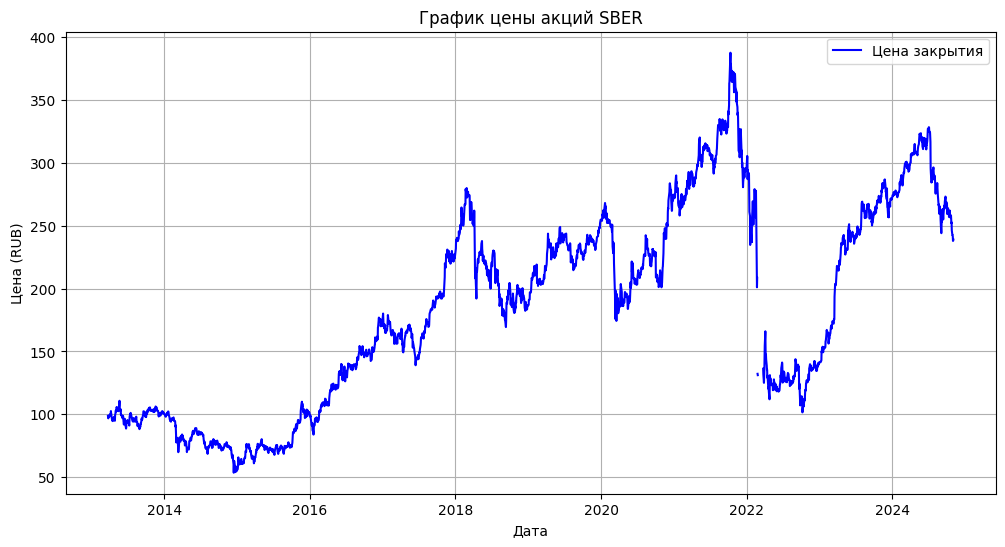

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(data_frames['SBER']['data_frame']['TRADEDATE'], data_frames['SBER']['data_frame']['CLOSE'], label='Цена закрытия', color='blue')
plt.title(f'График цены акций SBER')
plt.xlabel('Дата')
plt.ylabel('Цена (RUB)')
plt.legend()
plt.grid()
plt.show()

Судя по всему пропуски были из-за остановки торгов мосбиржей, то есть она работала, но из-за событий в мире цена изменялась слишком быстро и чтобы люди всё не сломали бумаги просто не давали продать и купить.

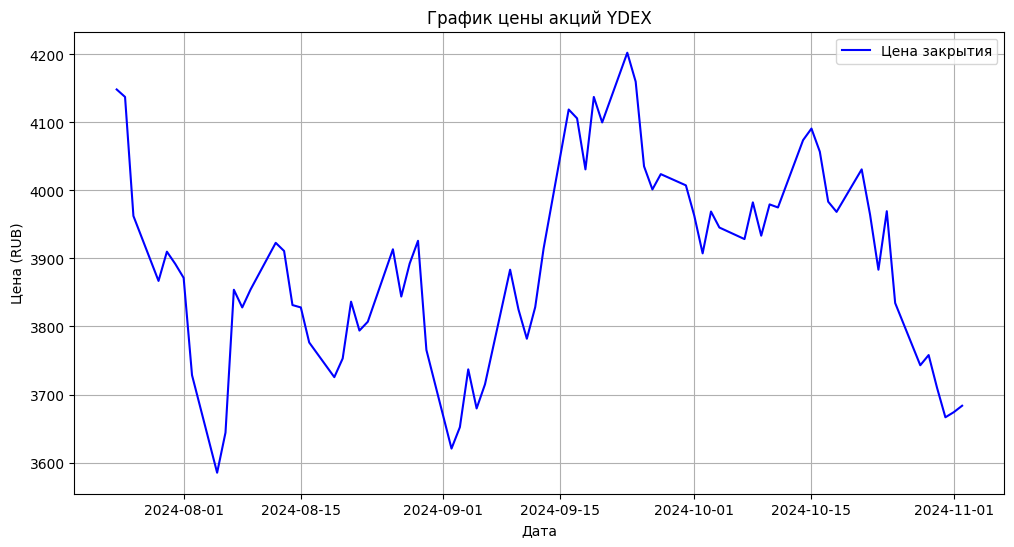

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(data_frames['YDEX']['data_frame']['TRADEDATE'], data_frames['YDEX']['data_frame']['CLOSE'], label='Цена закрытия', color='blue')
plt.title(f'График цены акций YDEX')
plt.xlabel('Дата')
plt.ylabel('Цена (RUB)')
plt.legend()
plt.grid()
plt.show()

Яндекс, наверное имел как и у сбера, но недавно яндекс полностью разделился и теперь его история в памяти мосбиржи такая молодая.

Заполним данные используя линейную интерполяцию. В примере посмотрим на компанию RKKE с пропуском больше 8%.

In [76]:
rkke = copy.deepcopy(normal_start_dataframe_data['RKKE'])

Но для начала посмотрим как работает.

In [77]:
data = normal_start_dataframe_data['SBER']['data_frame']
data['VOLUME'] = data['VOLUME'].replace(0, np.nan)
data['VALUE'] = data['VALUE'].replace(0, np.nan)
data.loc[[2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270]]

,TRADEDATE,OPEN,LOW,HIGH,CLOSE,VOLUME,VALUE
2245,2022-02-17,277.00,259.36,277.00,260.58,2.620887e+08,6.963998e+10
2246,2022-02-18,262.13,245.00,267.00,250.28,2.705947e+08,6.903378e+10
2247,2022-02-21,249.15,184.30,258.32,201.00,1.084508e+09,2.385837e+11
2248,2022-02-22,198.72,182.03,219.90,208.53,9.460206e+08,1.886633e+11
2249,2022-02-23,NaN,NaN,NaN,NaN,NaN,NaN
2250,2022-02-24,187.54,89.59,187.54,132.18,8.293559e+08,9.828140e+10
2251,2022-02-25,123.75,115.11,152.89,131.12,3.962872e+08,5.176981e+10
2252,2022-02-28,NaN,NaN,NaN,NaN,NaN,NaN
2253,2022-03-01,NaN,NaN,NaN,NaN,NaN,NaN
2254,2022-03-02,NaN,NaN,NaN,NaN,NaN,NaN


Подобным образом будет заполняться.

In [78]:
data.interpolate(method='linear').loc[[2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270]]

,TRADEDATE,OPEN,LOW,HIGH,CLOSE,VOLUME,VALUE
2245,2022-02-17,277.000000,259.360000,277.000000,260.580000,2.620887e+08,6.963998e+10
2246,2022-02-18,262.130000,245.000000,267.000000,250.280000,2.705947e+08,6.903378e+10
2247,2022-02-21,249.150000,184.300000,258.320000,201.000000,1.084508e+09,2.385837e+11
2248,2022-02-22,198.720000,182.030000,219.900000,208.530000,9.460206e+08,1.886633e+11
2249,2022-02-23,193.130000,135.810000,203.720000,170.355000,8.876882e+08,1.434723e+11
2250,2022-02-24,187.540000,89.590000,187.540000,132.180000,8.293559e+08,9.828140e+10
2251,2022-02-25,123.750000,115.110000,152.890000,131.120000,3.962872e+08,5.176981e+10
2252,2022-02-28,124.176471,115.994706,153.084706,131.421176,3.823564e+08,5.005936e+10
2253,2022-03-01,124.602941,116.879412,153.279412,131.722353,3.684256e+08,4.834890e+10
2254,2022-03-02,125.029412,117.764118,153.474118,132.023529,3.544949e+08,4.663845e+10


In [79]:
for secid, data in normal_start_dataframe_data.items():
    df = data['data_frame']
    df['VOLUME'] = df['VOLUME'].replace(0, np.nan)
    df['VALUE'] = df['VALUE'].replace(0, np.nan)
    data['data_frame'] = df.interpolate(method='linear')

По итогу дополнили все пропуски.

In [80]:
normal_start_dataframe_data['SBER']['data_frame'].loc[[2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270]]

,TRADEDATE,OPEN,LOW,HIGH,CLOSE,VOLUME,VALUE
2245,2022-02-17,277.000000,259.360000,277.000000,260.580000,2.620887e+08,6.963998e+10
2246,2022-02-18,262.130000,245.000000,267.000000,250.280000,2.705947e+08,6.903378e+10
2247,2022-02-21,249.150000,184.300000,258.320000,201.000000,1.084508e+09,2.385837e+11
2248,2022-02-22,198.720000,182.030000,219.900000,208.530000,9.460206e+08,1.886633e+11
2249,2022-02-23,193.130000,135.810000,203.720000,170.355000,8.876882e+08,1.434723e+11
2250,2022-02-24,187.540000,89.590000,187.540000,132.180000,8.293559e+08,9.828140e+10
2251,2022-02-25,123.750000,115.110000,152.890000,131.120000,3.962872e+08,5.176981e+10
2252,2022-02-28,124.176471,115.994706,153.084706,131.421176,3.823564e+08,5.005936e+10
2253,2022-03-01,124.602941,116.879412,153.279412,131.722353,3.684256e+08,4.834890e+10
2254,2022-03-02,125.029412,117.764118,153.474118,132.023529,3.544949e+08,4.663845e+10


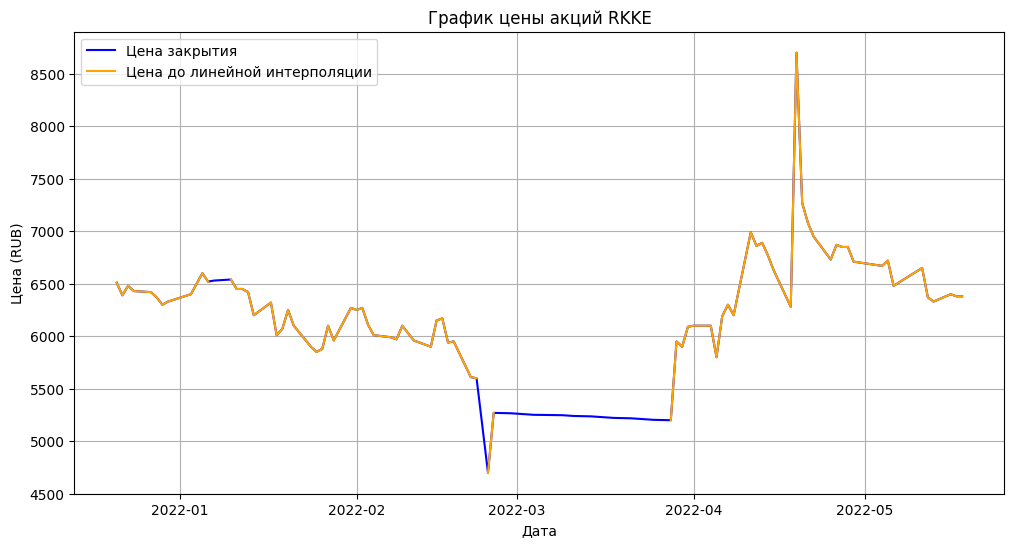

In [87]:
miss_range = list(range(1900,2000))
plt.figure(figsize=(12, 6))
plt.plot(normal_start_dataframe_data['RKKE']['data_frame']['TRADEDATE'].loc[miss_range], normal_start_dataframe_data['RKKE']['data_frame']['CLOSE'].loc[miss_range], label='Цена закрытия', color='blue')
plt.plot(rkke['data_frame']['TRADEDATE'].loc[miss_range], rkke['data_frame']['CLOSE'].loc[miss_range], label='Цена до линейной интерполяции', color='orange')
plt.title(f'График цены акций RKKE')
plt.xlabel('Дата')
plt.ylabel('Цена (RUB)')
plt.legend()
plt.grid()
plt.show()

Как можно видеть есть прямые линии на графики, которых нет в одной из историй, как раз их мы линейной интерполяцией и дополнили, какой-то более логичный способ заполнить данные будет найти очень сложно и для каждой бумаги надо будет делать это вручную, да и задача у нас не в этом.

И запомним данные.

In [84]:
upload_data_to_s3(normal_start_dataframe_data, 'preprocessed_data/')

Успешно сохранен в russian-stocks-quotes/preprocessed_data/secid_names.pkl
Успешно сохранен в russian-stocks-quotes/preprocessed_data/secids/APRI/APRI_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/preprocessed_data/secids/APRI/APRI_info.pkl
Успешно сохранен в russian-stocks-quotes/preprocessed_data/secids/KLVZ/KLVZ_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/preprocessed_data/secids/KLVZ/KLVZ_info.pkl
Успешно сохранен в russian-stocks-quotes/preprocessed_data/secids/ASTR/ASTR_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/preprocessed_data/secids/ASTR/ASTR_info.pkl
Успешно сохранен в russian-stocks-quotes/preprocessed_data/secids/AVAZP/AVAZP_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/preprocessed_data/secids/AVAZP/AVAZP_info.pkl
Успешно сохранен в russian-stocks-quotes/preprocessed_data/secids/AVAZ/AVAZ_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/preprocessed_data/secids/AVAZ/AVAZ_info.pkl
Успешно сохранен в russian-stocks-quotes/

И проверяем что нет пропусков, но информация на всякий случай сохраняется для тех пропусков, что мы заполнили сами.

In [93]:
test_data = download_data_from_s3('preprocessed_data/', ['RKKE'])
test_data['RKKE']['data_frame'].isna().sum()

Успешно получен из russian-stocks-quotes/preprocessed_data/secid_names.pkl
Успешно получен из russian-stocks-quotes/preprocessed_data/secids/RKKE/RKKE_info.pkl
Успешно получен из russian-stocks-quotes/preprocessed_data/secids/RKKE/RKKE_data_frame.pkl


,0
TRADEDATE,0
OPEN,0
LOW,0
HIGH,0
CLOSE,0
VOLUME,0
VALUE,0
